# INF8460 - Inference in Natural Languages
### Équipe 8, Membres: 
    - Raphael Croteau
    - Francois Vidal
    - Clément Maurel


## Modèles Simples  

! **Important** Ces modèles ne servent que de baseline. Notre 'vrai' modèle se trouve à la section "BERT + SRL"  

Utilisation de modèles simples afin de déterminer la complexité du problème. Parmis ceux-ci, un MLP simple avec softmax ainsi qu'un MLP utilisant BERT pour faire ses embeddings (bert n'était _pas_ entraîné avec le modèle).

In [0]:
import os
import time
import sklearn

import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk import TweetTokenizer
from keras.utils import np_utils
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from keras.models import Model
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

### Traiter et sauvegarder les plongements bert
Ces plongements peuvent prendre longtemps à traiter. Une méthode que nous avons adoptée pour se simplifier la vie était de traiter les données par groupes de 10'000 qui sont enregistrés dans des fichiers temporaires. Ces fichiers sont ensuite concatener pour former un seul grand tableau.

In [0]:
# uncomment pour utiliser google drive. Sinon les fichiers doivent être dans le meme dossier que le notebook
# from google.colab import drive
# drive.mount('/content/inf8460_projet')
# prefix = "./inf8460_projet/My Drive/inf8460_projet/"
prefix = "./"

# Lecture des données d'entraînement

train_data = pd.read_csv(os.path.join(prefix, 'snli_train.csv'))
train_data, validation_data = train_test_split(train_data, test_size=0.2)
nd_documents = len(train_data) 

train_data.head()

In [0]:
# Load une version pre-entrainé de bert
nb_features = 768
incremental_treatment = False # Permet le pretraitment indremental des données

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

In [0]:
def run_batch(data):
  """ Entraine bert avec data et renvoie la moyenne des dernier 4 layers ainsi que les labels de ces donnees """
  length_data = len(data)
  start = time.time()
  embedded = torch.zeros([len(data), nb_features])
  index = 0
  with torch.no_grad():
      for sent1, sent2 in zip(data['sentence1'], data['sentence2']):
          sentence = "[CLS] " + sent1 + " [SEP] " + sent2
          tokenized_sentence = tokenizer.tokenize(sentence)
          sep_index = tokenized_sentence.index("[SEP]") 
          ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_sentence)])
          segments = torch.tensor([0]*sep_index + [1]*(len(tokenized_sentence) - sep_index))
          encoded_layers, _ = model(ids, segments)

          mean_layers = torch.zeros([5, 768])
          for j in range(7, 12):
              mean_layers[j-7] = torch.mean(encoded_layers[j], 1)
          mean_layers = torch.mean(mean_layers, 0)
          embedded[index] = mean_layers

          if index % 1000 == 0:
              print(f"Document: {index}/{length_data}")

          index += 1
  print("Batch time : ", time.time() - start)

  le = preprocessing.LabelEncoder()
  return np.array(embedded), np.array(le.fit_transform(data["label1"]))

In [0]:
# Comme l'entrainement est tres long et qu'il y a beaucoup de donnees, on le fait en batch de 
# 10'000 qu'on enregistre dans des fichiers.
if not incremental_treatment:
  train_emb, train_labels_ = run_batch(train_data.head(10000))
else:
  i = 0
  j = 10000
  while i+j < len(train_data):
      emb, labels = run_batch(train_data[i:i+j])
      np.savetxt('train_emb_data{}.npy'.format(i), np.array(emb))
      np.savetxt('train_emb_labels{}.npy'.format(i), np.array(labels))
      i += j

  # Combine les fichiers train_emb_data{i} en un seul fichier
  i = 0
  j = 10000
  embs = None
  labels = None
  while True:
      name1 = 'train_emb_data{}.npy'.format(i)
      name2 = 'train_emb_labels{}.npy'.format(i)
      print("Reading : " + name1)
      a = np.loadtxt(name1)
      print("Reading : " + name2)
      b = np.loadtxt(name2)
      if embs is None:
          embs = a
          labels = b
      else:
          embs = np.vstack((embs, a))
          labels = np.vstack((labels, b))
      print(i)
      i += j
  np.savetxt('{}_embs.npy'.format(i), np.array(embs))
  np.savetxt('{}_labels.npy'.format(i), np.array(labels))

In [0]:
# Pretraite les donnees de n'ensemble de validation
valid_emb, valid_labels_ = run_batch(validation_data.head(5000))
np.savetxt('valid_emb_data.npy', np.array(valid_emb))
np.savetxt('valid_emb_labels.npy', np.array(valid_labels))

###  Chargement des plongements enregistrés

In [0]:
if incremental_treatment:
  train_emb = np.loadtxt(prefix + '140000_embs.npy')
  train_labels_ = np.loadtxt(prefix + "140000_labels.npy").flatten()
  valid_emb = np.loadtxt(prefix + 'valid_emb_data.npy')
  valid_labels_ = np.loadtxt(prefix + 'valid_emb_labels.npy')

# Transforme les labels en données catégoriques pour la prédiction
encoder = LabelEncoder()
encoder.fit(train_labels_)
train_labels = np_utils.to_categorical(encoder.transform(train_labels_))

encoder = LabelEncoder()
encoder.fit(valid_labels_)
valid_labels = np_utils.to_categorical(encoder.transform(valid_labels_))

### Modele simple FeedForwad avec plongements bert

In [0]:
# Model le plus simple, feed forward de 32 node
model = Sequential([
        Dense(32, input_shape=(len(train_emb[0]),), activation="sigmoid"),
        Dense(32, activation="sigmoid"),
        Dense(32, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
model.compile(
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

model.fit(
    train_emb,
    train_labels_,
    epochs=4,
    verbose=2,
    batch_size=8,
    validation_data=[valid_emb, valid_labels_])

### Modele simple LSTM avec plongements bert 

In [0]:
model_b = Sequential()
model_b.add(Bidirectional(LSTM(128), input_shape=(1, len(train_emb[0]))))
model_b.add(Dense(3, activation="softmax"))
model_b.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model_b.summary()

In [0]:
history = model_b.fit(
    train_emb.reshape((len(train_emb),1, len(train_emb[0]))),
    train_labels,
    epochs=3, 
    batch_size=32,
    validation_data=[valid_emb.reshape((len(valid_emb),1, len(valid_emb[0]))), valid_labels])
history

In [0]:
import matplotlib.pyplot as plt
def display_accuracy(model):
    plt.plot(model.history.history['acc'], label="Training set")
    plt.plot(model.history.history['val_acc'],label="Validation set")
    plt.legend()
    plt.show()

display_accuracy(model_b)

## Modèle Complexe : BERT + PoS / BERT + SRL

In [0]:
!pip install transformers
!pip install allennlp

In [0]:
import io
import os
import time
from datetime import datetime

import torch
import sklearn
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt

from torch import optim
from tqdm import tqdm, trange
from allennlp.predictors.predictor import Predictor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, SequentialSampler

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer

In [0]:
# uncomment pour utiliser google drive. Sinon les fichiers doivent être dans le meme dossier que le notebook
# from google.colab import drive
# drive.mount('/content/inf8460_projet')
# prefix = "./inf8460_projet/My Drive/inf8460_projet/"
prefix = "./"

In [0]:
# Une version de BERT très standard. L'entraînement est assez long
# bert_set = "bert-base-uncased"
# tokenizer_class = BertTokenizer
# bert_class = BertForSequenceClassification
# bert_config_class = BertConfig

# Une version de BERT _beaucoup_ plus rapide. Perte de ~3% en performance, gain de ~30% en temps d'entraînement
bert_set = "distilbert-base-uncased"
tokenizer_class = DistilBertTokenizer
bert_class = DistilBertForSequenceClassification
bert_config_class = DistilBertConfig

# Détermine si on entraîne le modèle en utilisant les tags sémantiques et si on utilise uniquement BERT pour l'inférence
with_srl = False
with_tags = True

batch_size = 4

### Traitement des Données

Le prétraitement !!pour le SRL!! prend _beaucoup_ de temps. 

Vous trouverez en suivant le lien suivant un fichier contenant 25'000 samples pré-traité pour srl : https://drive.google.com/open?id=11lB-5yiqRdYVKLMKFEhv12PDyeTjtN7- 

Placez ces données dans le même dossier que le notebook et allez directement à la section Chargement des données

In [0]:
# Lecture des données d'entraînement
# On met les differents sets dans des fichiers pour etre sur que cela soit coherent entre les differentes intances du notebook
all_data = pd.read_csv(os.path.join(prefix, 'snli_train.csv'))
all_train_data, all_valid_data = train_test_split(all_data, test_size=0.1)
all_train_data, all_test_data = train_test_split(all_train_data, test_size=0.05)

all_test_data.to_csv(prefix + '/test_samples.csv', index=False) # 5% de toutes les données
all_valid_data.to_csv(prefix + '/valid_samples.csv', index=False) # 10% d e toutes les données
all_train_data.to_csv(prefix + '/train_samples.csv', index=False) # 85% de toutes les données

In [0]:
# Permet de choisir le nombre de données à traiter afin de faire des itérations rapides. None pour toutes les utiliser
num_samples = None 
num_test = None

# On lit les fichiers enregistré plus haut (toujours dans le but de garder le tout cohérent)
all_test_data = pd.read_csv(os.path.join(prefix, 'test_samples.csv'))
all_valid_data = pd.read_csv(os.path.join(prefix, 'valid_samples.csv'))
all_train_data = pd.read_csv(os.path.join(prefix, 'train_samples.csv'))

if num_samples is not None:
  all_valid_data = all_valid_data[num_samples:num_samples+int(num_samples*0.1)]
  all_train_data = all_train_data[num_samples:num_samples+int(num_samples*0.90)]
if num_test is not None:
  all_test_data = all_test_data.head(num_test)

label_encoder = LabelEncoder()
all_train_labels = np.array(label_encoder.fit_transform(all_train_data["label1"])) 
all_valid_labels = np.array(label_encoder.fit_transform(all_valid_data["label1"]))
all_test_labels = np.array(label_encoder.fit_transform(all_test_data["label1"]))

print("{} Training samples".format(len(all_train_data)))
print("{} Validating samples".format(len(all_valid_data)))
print("{} Testing samples".format(len(all_test_data)))

In [0]:
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/bert-base-srl-2019.06.17.tar.gz")

def get_semtags(tokens):
  """ execute le Semantic role labeling sur l'entré tokenisé donnée. """
  if len(tokens) == 0:
    return []
  index_sep = np.nonzero(np.array(tokens)=="[SEP]")[0][0]
  sentence1 = ' '.join(tokens[1:index_sep]) # From after [CLS] to before the first [SEP]
  sentence2 = ' '.join(tokens[index_sep+1:-1]) # From after the first [SEP] to before the last [SEP]

  t1 = get_sem(sentence1)
  t2 = get_sem(sentence2)
  return ['[CLS]', *t1, '[SEP]', *t2, '[SEP]']

def get_sem(sentence):
  """ execute le Semantic role labeling sur la phrase tokenisé donnée. 
      Retourne un ensemble de "O" (~=unknown) si aucune représentation n'est trouvée
      En cas d'ambiguité, retourne la représentation trouvant le plus grand nombre d'étiquettes"""
  l = [d['tags'] for d in predictor.predict(sentence=sentence)['verbs']]
  if len(l) == 0:
    return np.full((1, sentence.count(" ") + 1), 'O').tolist()[0]
  index_best = np.array([labels.count('O') for labels in l]).argmin()
  return l[index_best]

In [0]:
# Fonctions utilitaire pour faire du part of speech sur les WordPiece de bert
def bert_token_to_regular(tokens):
  """ Transforme les tokens pour bert de forme ["sleep", "##ing"] en tokens normal -> ["sleeping"] """
  out = []
  for x in tokens:
    if x[0:2] == "##":
      out[-1] += x[2:]
    else:
      out.append(x)
  return out

def get_tags(tokens):
  """ Etiquette les tokens """
  return [t for w,t in bert_token_to_regular(nltk.pos_tag(tokens))]

def tags_to_bert(tags, bert_tokens):
  """ Etiquette les tokens de bert a partir des tags normaux generés par bert_token_to_regular et get_tags """
  out = []
  j = 0
  for i, x in enumerate(bert_tokens):
    if x[0:2] == "##":
      out.append(out[-1])
    elif x == "[CLS]" or x == "[SEP]":
      out.append("[PAD]")
      j += 1
    else:
      out.append(tags[j])
      j += 1
  return out

In [0]:
# Formatte les données dans un format compatible avec BERT (tokenisation, conversion en input id, padding, masques d'attentions et format torch.tensor)
# Inspiré du blog de Chris McCormick : https://mccormickml.com/2019/07/22/BERT-fine-tuning/
MAX_LEN= 128
def format_bert(data, _tokenizer):
  """ Formate des donnees dans un dataframe ayant les colonnes [sentence1] [sentence2] afin quelle puisse etre utiliser avec la lib hungingface """

  print("\nTokenize les entrées"); start = time.time()
  tokenized_texts = [["[CLS]", *_tokenizer.tokenize(sent1), "[SEP]", *_tokenizer.tokenize(sent2), "[SEP]"] for sent1, sent2 in zip(data['sentence1'], data['sentence2'])]
  print("\tTerminé : {} secondes".format(time.time() - start))
  
  if with_tags:
    if with_srl:
      print("Etiquetage de labels sémantiques"); start = time.time()
      tagged_texts = [tags_to_bert(get_semtags(bert_token_to_regular(tokens)), tokens) for tokens in tokenized_texts]
    else:
      print("Etiquetage morphosyntaxique"); start = time.time()
      tagged_texts = [tags_to_bert(get_tags(tokens), tokens) for tokens in tokenized_texts]
    print("\tTerminé : {} secondes".format(time.time() - start))
  else:
    tagged_texts = None

  print("Pad les entrées et les transformes en ids pour bert"); start = time.time()
  input_ids = pad_sequences([_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_ids = [_tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  print("\tTerminé : {} secondes".format(time.time() - start))

  print("Créer les masques d'attention (1 si un mot est présent)"); start = time.time()
  attention_masks = []
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  print("\tTerminé : {} secondes".format(time.time() - start))
  return input_ids, attention_masks, tagged_texts

start = time.time()
tokenizer = tokenizer_class.from_pretrained(bert_set, do_lower_case=True)

# # Traiter les donnees train
t_input_ids, t_attention_masks, t_semtags = format_bert(all_train_data, tokenizer)

train_inputs = torch.tensor(t_input_ids)
train_masks = torch.tensor(t_attention_masks)
train_labels = torch.tensor(all_train_labels)


# # Traiter les donnees validation
v_input_ids, v_attention_masks, v_semtags = format_bert(all_valid_data, tokenizer)

validation_inputs = torch.tensor(v_input_ids)
validation_masks = torch.tensor(v_attention_masks)
validation_labels = torch.tensor(all_valid_labels)


# # Traiter les donnees de test
te_input_ids, te_attention_masks, te_semtags= format_bert(all_test_data, tokenizer)

testing_inputs = torch.tensor(te_input_ids)
testing_masks = torch.tensor(te_attention_masks)
testing_labels = torch.tensor(all_test_labels)

# Transforme les semtags trouve precedemment en format categorique
all_semtags = set()
for semtags in t_semtags + v_semtags + te_semtags:
  all_semtags = all_semtags.union(set(semtags))
semtag_encoder = LabelEncoder()
semtag_encoder.fit(list(all_semtags))

def semtags_to_categorical(semtag_set):
  for i, semtags in enumerate(semtag_set):
    semtag_set[i] = semtag_encoder.transform(semtags)
  semtag_set = pad_sequences(semtag_set, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  return semtag_set

scaler = Normalizer(norm="max")
t_semtags = semtags_to_categorical(t_semtags)
train_semtags = scaler.fit_transform(torch.tensor(t_semtags))

v_semtags = semtags_to_categorical(v_semtags)
validation_semtags = scaler.transform(torch.tensor(v_semtags))

te_semtags = semtags_to_categorical(te_semtags)
test_semtags = scaler.transform(torch.tensor(te_semtags))

# Le traitement peut etre tres long. On sauvegarde la sortie dans des fichiers pour pouvoir iterer plus rapidement
np.savetxt(os.path.join(prefix, 'train_inputs.csv'), train_inputs, delimiter=",")
np.savetxt(os.path.join(prefix, 'train_masks.csv'), train_masks, delimiter=",")
np.savetxt(os.path.join(prefix, 'train_labels.csv'), train_labels, delimiter=",")
np.savetxt(os.path.join(prefix, 'train_semtags.csv'), train_semtags, delimiter=",")

np.savetxt(os.path.join(prefix, 'validation_inputs.csv'), validation_inputs, delimiter=",")
np.savetxt(os.path.join(prefix, 'validation_masks.csv'), validation_masks, delimiter=",")
np.savetxt(os.path.join(prefix, 'validation_labels.csv'), validation_labels, delimiter=",")
np.savetxt(os.path.join(prefix, 'validation_semtags.csv'), validation_semtags, delimiter=",")

np.savetxt(os.path.join(prefix, 'testing_inputs.csv'), testing_inputs, delimiter=",")
np.savetxt(os.path.join(prefix, 'testing_masks.csv'), testing_masks, delimiter=",")
np.savetxt(os.path.join(prefix, 'testing_labels.csv'), testing_labels, delimiter=",")
np.savetxt(os.path.join(prefix, 'test_semtags.csv'), test_semtags, delimiter=",")

print("Terminé : {} secondes".format(time.time() - start))

### Chargement des données

In [0]:
# Chargement des données pré-traité (voir cellule ci-dessus)
train_inputs = torch.tensor(np.loadtxt(os.path.join(prefix, 'train_inputs1.csv'), delimiter=",")).long()
train_masks = torch.tensor(np.loadtxt(os.path.join(prefix, 'train_masks1.csv'), delimiter=",")).long()
train_labels = torch.tensor(np.loadtxt(os.path.join(prefix, 'train_labels1.csv'), delimiter=",")).long()
train_semtags = torch.tensor(np.loadtxt(os.path.join(prefix, 'train_semtags1.csv'), delimiter=",")).float()

validation_inputs = torch.tensor(np.loadtxt(os.path.join(prefix, 'validation_inputs1.csv'), delimiter=",")).long()
validation_masks = torch.tensor(np.loadtxt(os.path.join(prefix, 'validation_masks1.csv'), delimiter=",")).long()
validation_labels = torch.tensor(np.loadtxt(os.path.join(prefix, 'validation_labels1.csv'), delimiter=",")).long()
validation_semtags = torch.tensor(np.loadtxt(os.path.join(prefix, 'validation_semtags1.csv'), delimiter=","))

testing_inputs = torch.tensor(np.loadtxt(os.path.join(prefix, 'testing_inputs1.csv'), delimiter=",")).long()
testing_masks = torch.tensor(np.loadtxt(os.path.join(prefix, 'testing_masks1.csv'), delimiter=",")).long()
testing_labels = torch.tensor(np.loadtxt(os.path.join(prefix, 'testing_labels1.csv'), delimiter=",")).long()
test_semtags = torch.tensor(np.loadtxt(os.path.join(prefix, 'test_semtags1.csv'), delimiter=",")).float()

In [0]:
# Creer les datasets
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_semtags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_semtags)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

testing_data = TensorDataset(testing_inputs, testing_masks, testing_labels, test_semtags)
testing_sampler = SequentialSampler(testing_data)
testing_dataloader = DataLoader(testing_data, sampler=testing_sampler, batch_size=batch_size)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

### Définition du Modèle

In [0]:
class MLP(nn.Module):
    """ Modèle PyTorch permettant de lier BERT à un MLP/couche de neuronnes """
    def __init__(self, with_tags):
        super(MLP, self).__init__()
        self.with_tags = with_tags
        config = bert_config_class.from_pretrained(bert_set)
        config.output_hidden_states = True
        config.num_labels = 3

        self.pool = nn.AvgPool1d(256, stride=1024)
        self.bert = bert_class.from_pretrained(bert_set, config=config)
        self.layers = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
        self.mlp_loss = nn.CrossEntropyLoss()

    def format_input(self, hidden_state_layer, tags):
        """ Lie un couche caché de bert à un vecteur de tags unidimensionnel.
            Utilise un algorithme de pooling (voir self.pool) pour transformer le layer en un vecteur 1d et le concatene avec les tags """
        b = self.pool(hidden_state_layer)
        b = b.reshape((hidden_state_layer.shape[0], hidden_state_layer.shape[1])) 
        return torch.cat((b, tags.float()), 1)
        
    def forward(self, ids, attention_mask, tags, labels=None):
        if labels is not None:
          loss_bert, a, hidden_states = self.bert(ids, attention_mask=attention_mask, labels=labels)
          if not self.with_tags:
            return loss_bert
          
          mlp_inputs = self.format_input(hidden_states[-1], tags)
          out_mlp = self.layers(mlp_inputs)
          return loss_bert + self.mlp_loss(out_mlp, _labels)
        else:
          logits, hidden_states = self.bert(ids, attention_mask=attention_mask)
          if not self.with_tags:
            return logits
          
          mlp_inputs = self.format_input(hidden_states[-1], tags)
          return self.layers(mlp_inputs)

### Entrainement du Baseline

In [0]:
baseline = MLP(with_tags = False)
model = baseline
model.cuda()

In [0]:
# Entrainement et validation de BERT avec notre corpus
def accuracy(got, expected):
  """ Calcule le pourcentage des labels prédits correctement """
  got_flattened = np.argmax(got, axis=1).flatten()
  expected_flattened = expected.flatten()
  return np.sum(got_flattened == expected_flattened) / len(expected_flattened)

# optimizer/settings de BERT
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_parameters, lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=len(train_data)*0.05, num_training_steps=len(train_data)*0.95)

# Store our loss and accuracy for plotting
generations = 6
for _ in trange(generations, desc="Generation"):
  # ==================== Training Step =======================
  model.train()  
  total_loss = 0
  for group in train_dataloader:
    group = tuple(t.to(device) for t in group) # Transfer le groupe sur le gpu
    _input_ids, _input_mask, _labels, _tags = group

    # Forward Pass
    loss = model(_input_ids, attention_mask=_input_mask, tags=_tags, labels=_labels)

    # Backpass
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad() # Remet le gradient du loss/optimizer à Zero. Sinon ils s'accumulent à travers le groupes et pollue les résulats du backpass
    total_loss += loss.item()
    # ========================================================

  # ==================== Validation Step =====================
  model.eval()
  total_valid_accuracy = 0
  for group in validation_dataloader:
    group = tuple(t.to(device) for t in group)
    _input_ids, _input_mask, _labels, _tags = group

    # Feedfoward : Utilise le logits comme prédiction
    with torch.no_grad():
        logits = model(_input_ids, attention_mask=_input_mask, tags=_tags)     
    # Déplace le tout vers le CPU pour l'analyse
    logits = logits.detach().cpu().numpy()
    label_ids = _labels.to('cpu').numpy()
    total_valid_accuracy += accuracy(logits, label_ids)
    # ========================================================  
  print("Loss: {}\tVal Acc: {}".format(
      total_loss/len(train_dataloader),
      total_valid_accuracy/len(validation_dataloader)))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("# Params : ", sum([np.prod(p.size()) for p in model_parameters]))

### Entrainement du Modèle

In [0]:
model = MLP(with_tags=with_tags)
model.cuda()

In [0]:
# Entrainement et validation de BERT avec notre corpus
def accuracy(got, expected):
  """ Calcule le pourcentage des labels prédits correctement """
  got_flattened = np.argmax(got, axis=1).flatten()
  expected_flattened = expected.flatten()
  return np.sum(got_flattened == expected_flattened) / len(expected_flattened)

# optimizer/settings de BERT
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_parameters, lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=len(train_data)*0.05, num_training_steps=len(train_data)*0.95)

# Store our loss and accuracy for plotting
generations = 6
for _ in trange(generations, desc="Generation"):
  # ==================== Training Step =======================
  model.train()  
  total_loss = 0
  for group in train_dataloader:
    group = tuple(t.to(device) for t in group) # Transfer le groupe sur le gpu
    _input_ids, _input_mask, _labels, _tags = group

    # Forward Pass
    loss = model(_input_ids, attention_mask=_input_mask, tags=_tags, labels=_labels)

    # Backpass
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad() # Remet le gradient du loss/optimizer à Zero. Sinon ils s'accumulent à travers le groupes et pollue les résulats du backpass
    total_loss += loss.item()
    # ========================================================

  # ==================== Validation Step =====================
  model.eval()
  total_valid_accuracy = 0
  for group in validation_dataloader:
    group = tuple(t.to(device) for t in group)
    _input_ids, _input_mask, _labels, _tags = group

    # Feedfoward : Utilise le logits comme prédiction
    with torch.no_grad():
        logits = model(_input_ids, attention_mask=_input_mask, tags=_tags)     
    # Déplace le tout vers le CPU pour l'analyse
    logits = logits.detach().cpu().numpy()
    label_ids = _labels.to('cpu').numpy()
    total_valid_accuracy += accuracy(logits, label_ids)
    # ========================================================  
  print("Loss: {}\tVal Acc: {}".format(
      total_loss/len(train_dataloader),
      total_valid_accuracy/len(validation_dataloader)))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("# Params : ", sum([np.prod(p.size()) for p in model_parameters]))

In [0]:
# Enregistre le modèle dans un fichier. Permet de par la suit re-charger ce même modèle (voir cellule ci-dessous)

date_time = datetime.now().strftime("%m-%d-%Y_%Hh%Mm%Ss")
torch.save(model, prefix + "model_{}.pth".format(date_time))

In [0]:
# Charge le modèle à partir d'un fichier. Soit pour continuer l'entrainement, soit pour générer les prédictions de test.

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

# model = torch.load(prefix + "model_12-09-2019_01h00m52s.pth")
# model.cuda()

### Validation du Modèle

In [0]:
# Entrainement et validation de BERT avec des donnees qu'il n'a jamais vues
import time
start = time.time()
# ==================== Test Step =====================
model.eval()
num_steps, total_accuracy = 0, 0
all_labels = None
for group in testing_dataloader:
  group = tuple(t.to(device) for t in group)
  _input_ids, _input_mask, _labels, _tags = group

  # Feedfoward : Utilise le logits comme prédiction
  with torch.no_grad():
      logits = model(_input_ids, attention_mask=_input_mask, tags=_tags)     
  # Déplace le tout vers le CPU pour l'analyse
  logits = logits.detach().cpu().numpy()
  label_ids = _labels.to('cpu').numpy()
  pred_labels = np.argmax(logits, axis=1).flatten()
  total_accuracy += sklearn.metrics.accuracy_score(pred_labels, label_ids)
  if all_labels is None:
    all_labels = pred_labels
  else:
    all_labels = np.hstack((all_labels, pred_labels))

  num_steps += 1
  # ========================================================  
print("Val Acc: {}".format(total_accuracy/num_steps))
print("Took : {} seconds".format(time.time() - start))

In [0]:
# Copié de : https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [0]:
from collections import defaultdict
total_contradiction = len([x for x in all_test_data["label1"] if x == "contradiction"])
total_entailment = len([x for x in all_test_data["label1"] if x == "entailment"])
total_neutral = len([x for x in all_test_data["label1"] if x == "neutral"])

print("Total Contradiction : ", total_contradiction)
print("Total Entailment : ", total_entailment)
print("Total Neutral : ", total_neutral)

string_labels = label_encoder.inverse_transform(all_labels)
pred_contradiction = len([x for x in string_labels if x == "contradiction"])
pred_entailment = len([x for x in string_labels if x == "entailment"])
pred_neutral = len([x for x in string_labels if x == "neutral"])

print("\nPred Contradiction : ", pred_contradiction)
print("Pred Entailment : ", pred_entailment)
print("Pred Neutral : ", pred_neutral)

d = {'contradiction': defaultdict(int), 'entailment': defaultdict(int), 'neutral': defaultdict(int)}
for i in range(len(string_labels)):
  d[all_test_data["label1"][i]][string_labels[i]] += 1
data = np.array([[d['contradiction']['contradiction']/total_contradiction, d['contradiction']['entailment']/total_contradiction, d['contradiction']['neutral']/total_contradiction],
        [d['entailment']['contradiction']/total_entailment, d['entailment']['entailment']/total_entailment, d['entailment']['neutral']/total_entailment],
        [d['neutral']['contradiction']/total_neutral, d['neutral']['entailment']/total_neutral, d['neutral']['neutral']/total_neutral]])
data

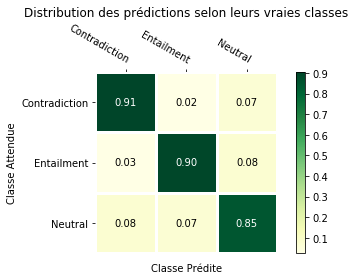

In [64]:
# Genere un graphique permettant la comparaison des performances selon les différences classes
# Heatmap de prediction vs réalité par classe
fig, ax = plt.subplots()
headers = ["Contradiction", "Entailment", "Neutral"]
im, cbar = heatmap(data, headers, headers, ax=ax,
                   cmap="YlGn", cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
ax.set_title("Distribution des prédictions selon leurs vraies classes")
ax.set_ylabel("Classe Attendue")
ax.set_xlabel("Classe Prédite")
fig.tight_layout()
# fig.set_size_inches(18.5, 10.5)
fig.savefig(prefix + "pred_vs_real.png", dpi=100)
plt.show()

### Generation des résultats sur snli_test.csv


In [0]:
# Lecture des données d'entraînement
start = time.time()
f_test_data = pd.read_csv(os.path.join(prefix, 'snli_test.csv'))
test_ids, test_masks, test_semtags = format_bert(f_test_data, tokenizer)

test_tags = tags_to_categorical(test_semtags)

test_tags = torch.tensor(test_tags)
test_ids = torch.tensor(test_ids)
test_masks = torch.tensor(test_masks)

t_data = TensorDataset(test_ids, test_masks, test_tags)
t_sampler = SequentialSampler(t_data)
test_dataloader = DataLoader(t_data, sampler=t_sampler, batch_size=batch_size)
print("Terminé : {} secondes".format(time.time() - start))

In [0]:
import time
start = time.time()
# ==================== Predicting Step =====================
model.eval()
num_steps, total_accuracy = 0, 0
all_labels = None
for group in test_dataloader:
  group = tuple(t.to(device) for t in group)
  _input_ids, _input_mask, _tags = group
  with torch.no_grad():
      logits = model(_input_ids, attention_mask=_input_mask, tags=_tags)     
  # Déplace le tout vers le CPU pour utilisation ultérieure
  logits = logits.detach().cpu().numpy()
  labels = np.argmax(logits, axis=1).flatten()
  if all_labels is None:
    all_labels = labels
  else:
    all_labels = np.hstack((all_labels, labels))
  num_steps += 1
  # ========================================================  
print("Took : {} seconds".format(time.time() - start))
f_test_data["label1"] = label_encoder.inverse_transform(all_labels)

In [0]:
# Écrit le fichier de soumission
submission = f_test_data[["id", "label1"]]
submission.to_csv(prefix + '/submission.csv', index=False)
submission.head()